# Optional Lab - Simple Neural Network
In this lab, we will build a small neural network using Numpy. It will be the same "coffee roasting" network you implemented in Tensorflow.
   <center> <img  src="./images/C2_W1_CoffeeRoasting.png" width="400" />   <center/>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from lab_utils_common import dlc, sigmoid
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## DataSet
This is the same data set as the previous lab.

In [2]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


Let's plot the coffee roasting data below. The two features are Temperature in Celsius and Duration in minutes. [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as the temperature rises, the duration should shrink. 

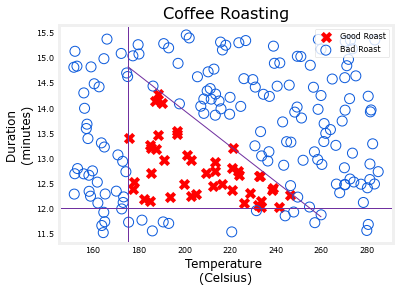

In [3]:
plt_roast(X,Y)

### Normalize Data
To match the previous lab, we'll normalize the data. Refer to that lab for more details

In [4]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


## Numpy Model (Forward Prop in NumPy)
<center> <img  src="./images/C2_W1_RoastingNetwork.PNG" width="200" />   <center/>  
Let's build the "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations.

As described in lecture, it is possible to build your own dense layer using NumPy. This can then be utilized to build a multi-layer neural network. 

<img src="images/C2_W1_dense2.PNG" width="600" height="450">

In the first optional lab, you constructed a neuron in NumPy and in Tensorflow and noted their similarity. A layer simply contains multiple neurons/units. As described in lecture, one can utilize a for loop to visit each unit (`j`) in the layer and perform the dot product of the weights for that unit (`W[:,j]`) and sum the bias for the unit (`b[j]`) to form `z`. An activation function `g(z)` can then be applied to that result. Let's try that below to build a "dense layer" subroutine.

In [5]:
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units|
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):               
        w = W[:,j]                                    
        z = np.dot(w, a_in) + b[j]         
        a_out[j] = g(z)               
    return(a_out)

The following cell builds a two-layer neural network utilizing the `my_dense` subroutine above.

In [6]:
def my_sequential(x, W1, b1, W2, b2):
    a1 = my_dense(x,  W1, b1, sigmoid)
    a2 = my_dense(a1, W2, b2, sigmoid)
    return(a2)

We can copy trained weights and biases from the previous lab in Tensorflow.

In [7]:
W1_tmp = np.array( [[-8.93,  0.29, 12.9 ], [-0.1,  -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28,  0.96] )
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.41] )

### Predictions
<img align="left" src="./images/C2_W1_RoastingDecision.PNG"     style=" width:380px; padding: 10px 20px; " >

Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

Let's start by writing a routine similar to Tensorflow's `model.predict()`. This will take a matrix $X$ with all $m$ examples in the rows and make a prediction by running the model.

In [8]:
def my_predict(X, W1, b1, W2, b2):
    m = X.shape[0]
    p = np.zeros((m,1))
    for i in range(m):
        p[i,0] = my_sequential(X[i], W1, b1, W2, b2)
    return(p)

We can try this routine on two examples:

In [9]:
X_tst = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_tstn = norm_l(X_tst)  # remember to normalize
predictions = my_predict(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp)

To convert the probabilities to a decision, we apply a threshold:

In [10]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succinctly:

In [11]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Network function

This graph shows the operation of the whole network and is identical to the Tensorflow result from the previous lab.
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.   
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.  

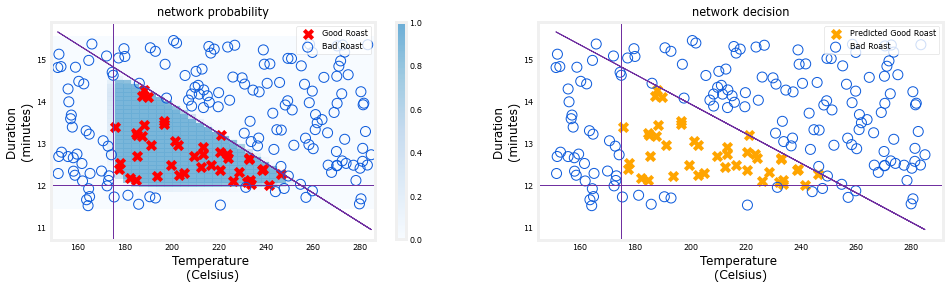

In [12]:
netf= lambda x : my_predict(norm_l(x),W1_tmp, b1_tmp, W2_tmp, b2_tmp)
plt_network(X,Y,netf)

## Congratulations!
You have built a small neural network in NumPy. 
Hopefully this lab revealed the fairly simple and familiar functions which make up a layer in a neural network. 